# Generates Feature Matrix Genes-GO-Terms 




In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import math
import urllib
import gzip
import colorsys
import pickle as pk
import os.path
from collections import defaultdict, Counter, ChainMap
import umap
import time
import json

import matplotlib.pyplot as plt
# %matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

## Functions

In [2]:

def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    # info.append(f"Density: {round(100. * nx.density(G), 3)} %")

    # if nx.is_weighted(G):
    #     info.append(f"Weighted: Yes")
        
    #     # Calculate the average degree considering edge weights for weighted graphs
    #     avg_weighted_degree = sum(weight for u, v, weight in G.edges(data=True)) / G.number_of_nodes()
    #     info.append(f"Average Weighted Degree: {round(avg_weighted_degree, 2)}")
    # else:
    #     info.append(f"Weighted: No")
        
    #     # Calculate the average degree as usual for unweighted graphs
    #     avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    #     info.append(f"Average Degree: {round(avg_degree, 2)}")

    info.append(f"Connected: {'Yes' if nx.is_connected(G) else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")

    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    
    return "\n".join(info)

### ID mappings

In [3]:


def download_mapping_file(url, filename):
    urllib.request.urlretrieve(url, filename)

def parse_mapping_file(filename):
    mapping = {}
    with gzip.open(filename, 'rt') as file:
        for line in file:
            if line.startswith('#'):  # Skip header and comments
                continue
            fields = line.strip().split('\t')
            # print(fields)
            if fields[0] == '9606':
                gene_symbol = fields[2]
                entrez_id = fields[1]
                # print(entrez_id)
                # ensembl_id = fields[5]
                # Additional mapping field
                gene_name = fields[10]

                # try: 
                #     ent_int = int(entrez_id)
                #     gene_name = fields[10]
                # except:
                #     gene_name = entrez_id

                if gene_symbol not in mapping:
                    mapping[gene_symbol] = {
                        'entrez_id': entrez_id,
                        # 'ensembl_id': ensembl_id,
                        'gene_name': gene_name
                    }
    return mapping


def convert_symbols_to_entrez(gene_symbols, mapping):
    entrez_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            entrez_ids.append(mapping[symbol]['entrez_id'])
    return entrez_ids

# def convert_symbols_to_ensembl(gene_symbols, mapping):
#     ensembl_ids = []
#     for symbol in gene_symbols:
#         if symbol in mapping:
#             ensembl_ids.append(mapping[symbol]['ensembl_id'])
#     return ensembl_ids

# Download Gene Info file (example using Homo sapiens)
filename = 'Homo_sapiens.gene_info.gz'
url = 'ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/' + filename

# download_mapping_file(url, filename)

# Parse mapping file
mapping = parse_mapping_file(filename)

# Generate a dictionary of all existing gene symbols and their corresponding Entrez IDs and Ensemble IDs
all_gene_symbols = list(mapping.keys())
all_entrez_ids = [mapping[symbol]['entrez_id'] for symbol in all_gene_symbols]
# all_ensembl_ids = [mapping[symbol]['ensembl_id'] for symbol in all_gene_symbols]
symbol_to_entrez = dict(zip(all_gene_symbols, all_entrez_ids))
# symbol_to_ensembl = dict(zip(all_gene_symbols, all_ensembl_ids))
entrez_to_symbols = {v: k for k, v in symbol_to_entrez.items()}
# ensembl_to_symbols = {v: k for k, v in symbol_to_ensembl.items()}


### load PPI data

In [4]:
path = '/Users/fmueller/work/NICE/GitNICE/Data/'


print('full PPI')
# PPI direct
G_ppi = nx.read_edgelist(path + 'PPIs/PPI_physical_elist.csv',data=False, delimiter=',')
print(Ginfo(G_ppi))
print('\nlcc PPI')

lcc = max(nx.connected_components(G_ppi), key=len)
G = nx.subgraph(G_ppi,lcc)

print(Ginfo(G))

full PPI
Graph Name: 
Graph Type: Graph
Number of Nodes: 18068
Number of Edges: 306914
Connected: No
Number of Connected Components: 2
Directed: No

lcc PPI
Graph Name: 
Graph Type: Graph
Number of Nodes: 18064
Number of Edges: 306911
Connected: Yes
Number of Connected Components: 1
Directed: No


In [42]:
G.nodes()

NodeView(('25777', '728378', '3091', '4149', '3655', '64806', '10667', '26060', '54903', '80005', '57188', '84324', '6146', '51121', '6342', '10488', '5610', '406888', '25959', '346171', '6242', '84451', '10101', '388324', '9569', '9636', '11322', '57348', '5987', '284058', '7874', '23072', '7529', '283450', '11166', '84864', '8536', '26279', '898', '1026', '11030', '84528', '53340', '116179', '7379', '10223', '3297', '7170', '23468', '201514', '115426', '359787', '57060', '255220', '4701', '84277', '6013', '79411', '10910', '11234', '56262', '388650', '7013', '11338', '4222', '84708', '51225', '87769', '8661', '9322', '4957', '57489', '26580', '90407', '5013', '84217', '84309', '406985', '6696', '6780', '6613', '7153', '9241', '64222', '51474', '90102', '27230', '136263', '351', '55611', '3042', '3050', '2197', '65005', '805', '815', '116173', '283578', '5468', '23764', '2703', '79669', '2019', '8816', '57462', '79745', '2048', '84125', '51361', '135398', '9166', '374395', '3934', '12

### load annotation data 

In [5]:

## GO - Functions
# d_attributes_sample = pk.load( open(path + "GO/GOupF2genes.pkl", "rb" ) )
# d_sample_attributes = pk.load( open(path + "GO/gene2GOF_up.pkl", "rb" ) )

# GO - components
d_attributes_sample = pk.load( open(path + "GO/GOupC2genes.pkl", "rb" ) )
d_sample_attributes = pk.load( open(path + "GO/gene2GOC_up.pkl", "rb" ) )

d_go_names = pk.load( open(path + "GO/d_gonames.pkl", "rb" ) )



### load GO tree


In [6]:
# downwards directed tree

# GO_F = pk.load( open( path + 'GO/tree/G_GOF.pkl', 'rb' ) )
# F_tip = pk.load( open( path + 'GO/tree/moltip.pkl', 'rb' ) )

GO_C = pk.load( open( path + 'GO/tree/G_GOC.pkl', 'rb' ) )
C_tip = pk.load( open( path + 'GO/tree/celltip.pkl', 'rb' ) )

# Make dict that connects subvolumes to any term in tree
d_goC_subvol = {}
c = 0
for do in GO_C.nodes():
    des_vol = len(nx.descendants(GO_C,do))+1
    d_goC_subvol[do] = len(nx.descendants(GO_C,do))+1


In [44]:
d_go_names[C_tip]

'cellular_component'

In [7]:
print('terms in tree')
print(len(nx.descendants(GO_C,C_tip)))

terms in tree
4183


### Construct feature matrix


In [ ]:


d_gene_terms_all = {}
c = 0
cc = 0

for gene in G.nodes():
     
    try:
        l_pure = d_sample_attributes[int(gene)]
        cc += 1
    except KeyError:
        l_pure = []
        
        
    # s_all = set(list(l_enr)+list(l_pure))
    # for shice:
    s_all = list(l_pure)

    if len(s_all) > 0:
        d_gene_terms_all[gene] = s_all
    # d_gene_terms_all[gene] = s_all


d_gene_idx_feat = {}
d_idx_gene_feat = {}
nn = 0      
        
# all terms
l_terms = []

for gene, l_t in sorted(d_gene_terms_all.items()):
    l_terms += l_t 
    d_gene_idx_feat[gene] = nn
    d_idx_gene_feat[nn] = gene
    nn += 1   
    
s_terms = set(l_terms)



### Some data sanity checks 

In [12]:
print('number of PPI nodes')
print(G.number_of_nodes())
print('\n')

print('number of genes with plain annotations')
# print(len(d_sample_attributes.keys()))
cc = 0
geneswithterms_on_PPI = set([str(x) for x in d_sample_attributes.keys()]) & set(G.nodes())
for k, v in d_sample_attributes.items():
    if len(v)>0 and str(k) in geneswithterms_on_PPI:
        cc += 1
print(cc)
print('\n')




number of PPI nodes
18064


number of genes with plain annotations
15538




In [13]:
from matplotlib_venn import venn2
def plot_venn_diagram(set1, set2, set1_name = 'set 1',set2_name = 'set 2'):
    # Create the Venn diagram
    venn = venn2([set1, set2], set_labels=(set1_name, set2_name))

    # Customize the Venn diagram colors
    venn.get_patch_by_id('10').set_color('lightblue')
    venn.get_patch_by_id('01').set_color('lightgreen')
    venn.get_patch_by_id('11').set_color('purple')

    # Add labels to the individual set regions
    set1_label = venn.get_label_by_id('10')
    set2_label = venn.get_label_by_id('01')
    overlap_label = venn.get_label_by_id('11')

    set1_label.set_text(len(set1 - set2))
    set2_label.set_text(len(set2 - set1))
    overlap_label.set_text(len(set1 & set2))


    # Set text color for the labels
    set1_label.set_color('#444444')
    set2_label.set_color('#444444')
    overlap_label.set_color('#444444')

    set1_label.set_fontsize(16)
    set2_label.set_fontsize(16)
    overlap_label.set_fontsize(16)

    i = 0
    for text in venn.set_labels:
        text.set_color('#444444')
        text.set_fontsize(10)
    i+=1
    

    # Display the Venn diagram
    plt.show()

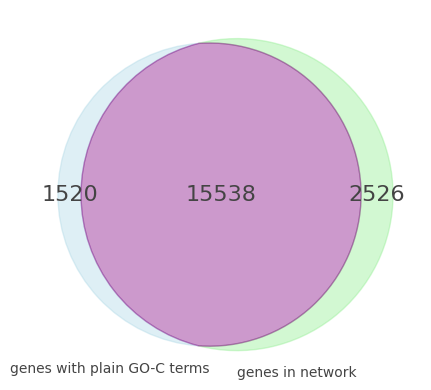

In [14]:
plot_venn_diagram(set([str(x) for x in d_sample_attributes.keys()]),set(G.nodes()),set1_name='genes with plain GO-C terms',set2_name='genes in network')

### Data preparation done

-----------------------------------------------------------------------------

### FEATURE MATRIX

In [15]:
# Create a feature matrix having genes as row indices sorted by d_gene_idx keys
# and features (annotations) as columns ordered like the set of annotation terms
t0 = time.time()


# dict to lookup annotation terms into column indices
d_t_idx = {}
c = 0
for t in sorted(s_terms):
    d_t_idx[t] = c
    c += 1
d_idx_go = {v:k for k,v in d_t_idx.items()}

# initialize feature matrix
# size (#rows,#cols)
size_featureMat = (len(d_gene_terms_all.keys()),len(s_terms))
FX = np.zeros(size_featureMat)

# iterating through rows (genes)
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    for t in d_gene_terms_all[gene]:
        row[d_t_idx[t]]=1
    c += 1
        

n_samples, n_features = FX.shape
print('number of features (annotations) as columns: %s' %n_features)
print('number of samples (genes) as rows: %s' %n_samples)

print('CPU time %s' %(time.time()-t0))



number of features (annotations) as columns: 1845
number of samples (genes) as rows: 15538
CPU time 0.27437901496887207


### weighted GO terms

In order to amplify more specific GO term multiply each GO column by

$$ -\log \frac{n}{N} $$

where $N$ is the number of all GO terms and $n$ is the subvolumen derived from the tree.

Thus it is the probability to find either the term itself or any even more specific term when choosing a term randomly.

This procedure should also allow to get around the feature selection steps. 

### weight scaling for elements in the feature matrix  

In [16]:
N_tree = GO_C.number_of_nodes()
print(N_tree)

c_no= 0
for col in range(len(FX[0,:])):
    # print(col)
    # if col < 10:
    go = d_idx_go[col]
    try:
        vol = d_goC_subvol[go]
    except KeyError:
        vol = 1
        c_no += 1
    weight = vol + 1
    p = -np.log(weight/N_tree)
    FX[:,col] *= p

print(c_no)

4184
2


In [19]:

n_samples, n_features = FX.shape
print('number of features/annotations (columns): %s' %n_features)
print('number of samples/genes (rows): %s' %n_samples)


number of features/annotations (columns): 1845
number of samples/genes (rows): 15538


### sanity of feature matrix

In [18]:
n_samples, n_features = FX.shape
print('number of features (columns): %s' %n_features)
print('number of samples (rows): %s' %n_samples)

# Count the zero entries
zero_count = np.count_nonzero(FX == 0)

print("Number of zero entries:", zero_count)

print("fraction of zero entries:", zero_count/n_samples/ n_features )


if np.isnan(FX).any():
    print("FX contains NaN values.")
else:
    print("FX does not contain NaN values.")
    

# Check for rows that sum up to zero
zero_sum_rows = np.where(FX.sum(axis=1) == 0)[0]

# Check for columns that sum up to zero
zero_sum_columns = np.where(FX.sum(axis=0) == 0)[0]

# Check if there are any zero-sum rows or columns
if zero_sum_rows.size > 0:
    print("There are rows that sum up to zero:", zero_sum_rows)
else:
    print("No rows sum up to zero.")

if zero_sum_columns.size > 0:
    print("There are columns that sum up to zero:", zero_sum_columns)
else:
    print("No columns sum up to zero.")



# Define a function to calculate matrix density
def matrix_density(matrix):
    num_nonzero = np.count_nonzero(matrix)
    total_elements = matrix.size
    density = num_nonzero / total_elements
    return density

density = matrix_density(FX)

print("Matrix density:", density)

number of features (columns): 1845
number of samples (rows): 15538
Number of zero entries: 28369245
fraction of zero entries: 0.9895922610918734
FX does not contain NaN values.
No rows sum up to zero.
No columns sum up to zero.
Matrix density: 0.010407738908126627


## FROM HERE MY OWN SPECIAL ANALYISIS STARTS

You don't need to care

I'll keep it though for later reference

### UMAP coordinates based on Feature matrix

In [20]:
# metric = 'euclidean'
metric = 'cosine'
t0 = time.time()

# for mind in np.arange(.2,4.,.4):
n_neighs = 50
mind = .9
spread = 1.

reducer = umap.UMAP(n_components=2,
                    n_neighbors=n_neighs, 
                    metric = metric, 
                    min_dist=mind, 
                    spread = spread, 
                    init = 'spectral', 
                    low_memory=True)

umap_pos = reducer.fit_transform(FX)


d_umappos = {}
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    xy = umap_pos[c,:].tolist()
    d_umappos[gene] = xy
    c += 1

print('UMAP time : %f ' %  (time.time()-t0))


UMAP time : 50.371117 


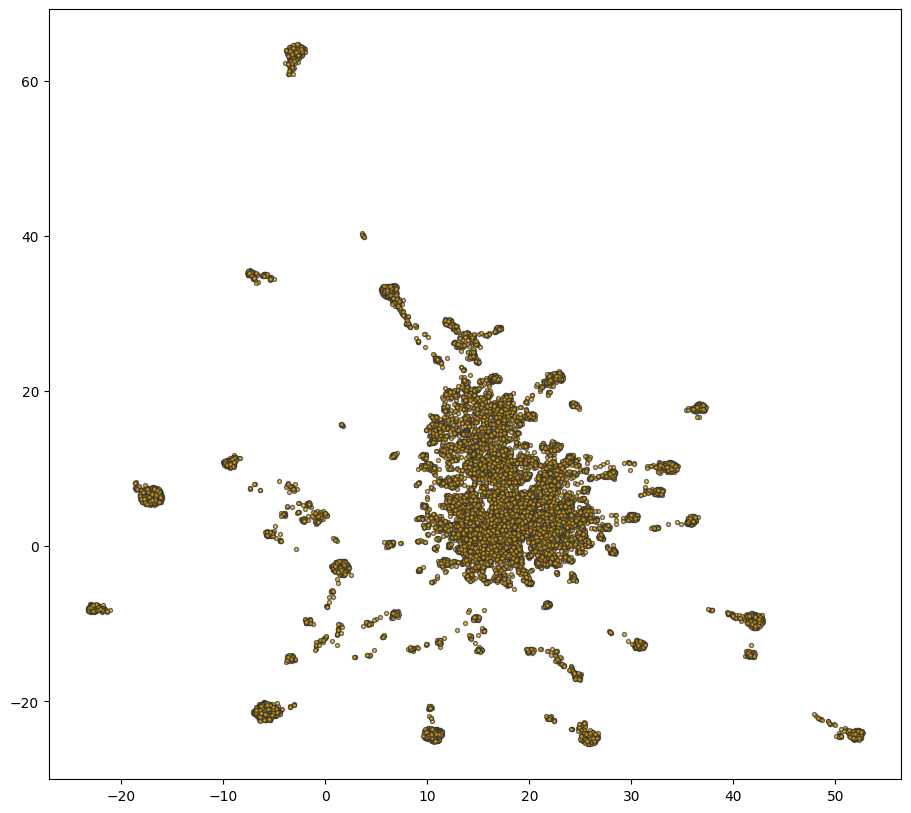

In [21]:

plt.figure(figsize=(11,10))
# plt.scatter(umap_pos[:,0],umap_pos[:,1], s = 20)
plt.scatter(umap_pos[:,0],umap_pos[:,1], s = 8,c='#f8b100',edgecolors='#333333',alpha=.7)

### GENE 2 GENE MATRIX & LINKAGE

generates levels of clustering

takes ca 10 mins

In [23]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
t0 = time.time()

D = dist.pdist(FX,metric = metric)

L = sch.linkage(D, method = 'average',metric = metric)
L[L<0.0] = 0.0


print('time.time(): %f' % (time.time()-t0))

time.time(): 325.670731


### evaluate the best number of clusters 

by considering the size of the biggest clusters versus the numnber of trivial clusters (single node).

It should be optimized to reduce the size of the largest while also not havong too many trivial clusters. 



### Silhouette Score

The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

To use it:

    Calculate the silhouette score for a range of number of clusters.
    Choose the number of clusters that maximize the silhouette score.

In [51]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform
condensed_D = squareform(D) 

# Choosing the number of clusters based on silhouette score
silhouette_scores = []
range_n_clusters = list(range(200, 800,20))  # Example range from 2 to 9 clusters
for n_clusters in range_n_clusters:
    labels = fcluster(L, n_clusters, criterion='maxclust')
    score = silhouette_score(condensed_D, labels, metric='precomputed')
    silhouette_scores.append(score)

optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print("The optimal number of clusters:", optimal_clusters)

The optimal number of clusters: 460


Text(0, 0.5, 'silhouette score')

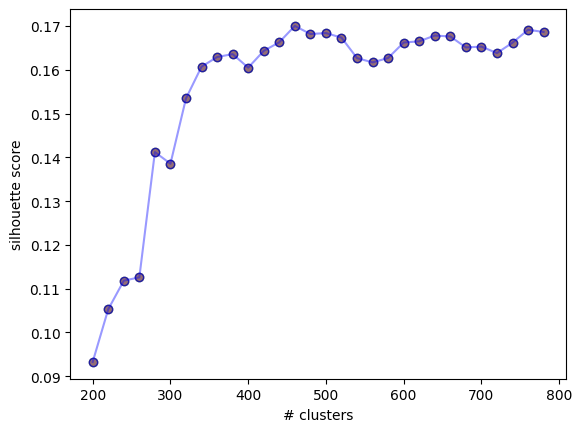

In [69]:
plt.plot(range_n_clusters, silhouette_scores, '-o', label='Silhouette Scores', color='b',alpha=.4)  # '-o' creates lines with circle markers
plt.scatter(range_n_clusters,silhouette_scores,c = '#f8b100',edgecolors='#333333',alpha=0.9)

plt.xlabel('# clusters')
plt.ylabel('silhouette score')

Elbow Method (typically slow)

The Elbow Method involves plotting the explained variance as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. This method can be adapted for hierarchical clustering by plotting the increase in the sum of squared distances as a function of the number of clusters.

To apply it in hierarchical clustering:

    Plot the linkage distance (the height at which each cluster merges) against the number of clusters (from merging).
    Look for a point in the plot where the rate of decrease sharply shifts (the "elbow"). This point often represents a good balance between not having too many clusters or too few.

In [70]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# # Plotting the dendrogram to visualize the elbow
# plt.figure(figsize=(10, 8))
# dendrogram(L)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('Sample index')
# plt.ylabel('Distance')
# plt.show()

# # Determine the optimal number of clusters by the elbow method
# # This step is more of a visual inspection method
# # You need to look at the plot and decide where the distance stops decreasing significantly with each additional cluster

# # Plotting the distance between successive clusters
# distances = L[:, 2]
# plt.figure(figsize=(10, 8))
# plt.plot(range(1, len(distances)+1), distances[::-1])
# plt.title('Elbow Method for Optimal Clusters')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distance of Merge')
# plt.grid(True)
# plt.show()

### my own method (very quick)

minimizing the number of nodes that belong to the largest cluster 

while 

keeping the number of trivial clusters low (trivial clusters have one single node only)




850


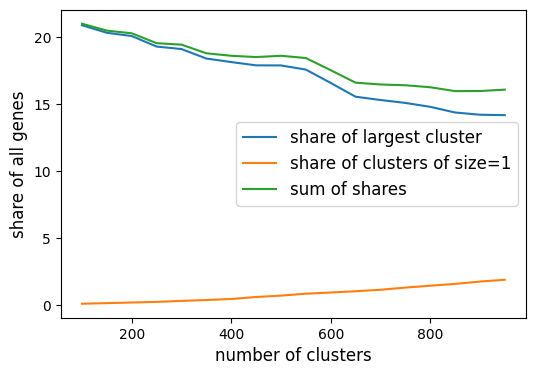

In [25]:
from scipy.cluster.hierarchy import fcluster


# EVALUATE OPTIMAL CLUSTER NUMBER
cs_range = range(100,1000,50)
l_frac_bigvs1 = []
l_frac_big = []
l_frac_s1 = []
for max_num_clusters in cs_range:
    l_cluster = fcluster(L, max_num_clusters, criterion='maxclust')
    # size of clusters
    d_c_s = {}
    for cl in set(l_cluster):
        d_c_s[cl] =  list(l_cluster).count(cl)

    for a,b in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True)[:1]:
        max_size = b
        max_size_frac = 100.*b/n_samples
#         print('size of largest cluster: %s (cov = %.0f%%)' %(max_size,max_size_frac))

    c_1_number = list(d_c_s.values()).count(1)
    c_1_number_frac = 100.*c_1_number/n_samples
    l_frac_big.append(max_size_frac)
    l_frac_s1.append(c_1_number_frac)
    l_frac_bigvs1.append(max_size_frac+c_1_number_frac)

index_min = np.argmin(np.array(l_frac_bigvs1))
#     print(index_min)
min_cs = cs_range[index_min]

print(min_cs)        


# min_cs = 1450

plt.figure(figsize=(6,4))

# plt.bar(range(len(d_c_s.keys()))[:40],sorted(d_c_s.values(),reverse = True)[:40])    
plt.plot(cs_range,l_frac_big,label='share of largest cluster')
plt.plot(cs_range,l_frac_s1, label = 'share of clusters of size=1')
plt.plot(cs_range,l_frac_bigvs1,label='sum of shares')

plt.legend(fontsize =12)
plt.xlabel('number of clusters',fontsize =12)
plt.ylabel('share of all genes',fontsize =12)

ax = plt.gca()
tick_color = 'k'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=10)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)



count the occurrence of cluster sizes

In [26]:
# from silouhette
# num_clusters = optimal_clusters

# from 2nd method
num_clusters = 600

l_cluster = fcluster(L, num_clusters, criterion='maxclust')

d_clID_size = Counter((l_cluster.tolist()))
print('clusterID , #genes in cluster')
c = 0 
sum = 0
for k, v in d_clID_size.items():
    c += 1
    sum += v
    # print(k,v)
print('there are %s clusters that contain %s genes in total' %(c,sum))

# dict for size distribution of clusters
d_size_freq = dict(Counter(d_clID_size.values()))


clusterID , #genes in cluster
there are 600 clusters that contain 15538 genes in total


cluster size distribution

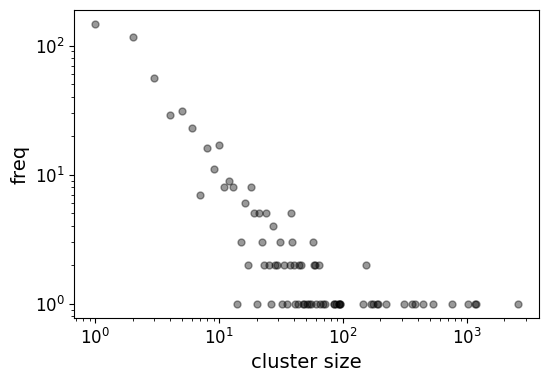

In [27]:
fig_fontsize = 14

plt.figure(figsize=(6,4))
# plt.bar(range(len(d_c_s.keys()))[:40],sorted(d_c_s.values(),reverse = True)[:40])    
plt.scatter(d_size_freq.keys(),d_size_freq.values(),c = 'k',s = 25,alpha = .4)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('cluster size',fontsize =fig_fontsize)
plt.ylabel('freq',fontsize =fig_fontsize)

ax = plt.gca()
tick_color = 'k'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=fig_fontsize-2)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)


Color nodes according to clusters

Not all clusters get its own color as they are too many

Take a minimal cluster size and assign colors only to clusters that are bigger 

In [28]:
def generate_colors(n):
    # Generate equally spaced Hue values
    hues = [i/n for i in range(n)]
    
    # Set Saturation and Lightness to fixed values
    saturation = 0.5
    lightness = 0.5
    
    # Convert HSL colors to RGB colors and then to hex colors
    rgb_colors = [colorsys.hls_to_rgb(hue, lightness, saturation) for hue in hues]
    hex_colors = [f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" for r, g, b in rgb_colors]
    
    return hex_colors

# minimal size of a cluster to get a color
min_size = 100

l_small_clusterIDS = [c for c, s in d_clID_size.items() if s < min_size]
print('Only clusters bigger than %s genes get colors.' %min_size)
print('The rest will be gray.')

print('Thus we need %s different colors.' %(len(set(l_cluster))-len(l_small_clusterIDS)))

# generate as many colors as we have bigger clusters
l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
rd.shuffle(l_col)
# l_col = cemm_pal(len(set(l_cluster)))
d_cl_col = {}
c = 0
for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
    if size < min_size:
        d_cl_col[cl] = '#888888'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1

# assign colors to each node
d_node_col = {}
d_sym_col = {}

for n, cl in enumerate(l_cluster):
    col = d_cl_col[cl]
    gene = d_idx_gene_feat[n]
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = col
    d_sym_col[sym] = col


non_dis_genes = set(G.nodes) - set(d_node_col.keys())
# include the non-annotated nodes as well
non_dis_col = '#444444'
for gene in non_dis_genes:
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = non_dis_col
    d_sym_col[sym] = non_dis_col




Only clusters bigger than 100 genes get colors.
The rest will be gray.
Thus we need 18 different colors.


### cluster 2 genes dict

In [29]:
# make dict with clusterID as keys and set of genes as values
d_cl_setgenes = defaultdict(list)

for n, cl in enumerate(l_cluster):
    gene = d_idx_gene_feat[n]
    d_cl_setgenes[cl].append(gene)

# and vice versa
d_gene_clID = {}
for clID, set_genes in d_cl_setgenes.items():
    for gene in set_genes:
        d_gene_clID[gene] = clID



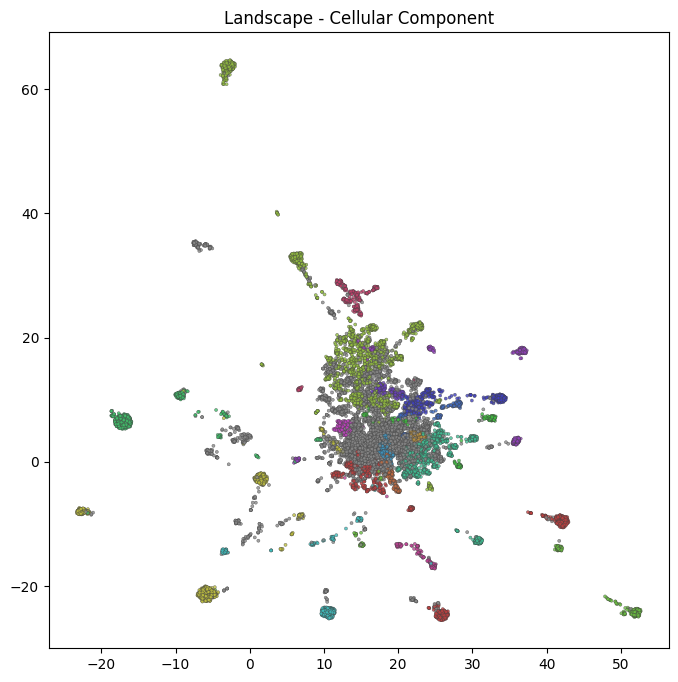

In [30]:
# shuffle colors

rd.shuffle(l_col)
# l_col = cemm_pal(len(set(l_cluster)))
d_cl_col = {}
c = 0
for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
    if size < min_size:
        d_cl_col[cl] = '#888888'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1

# assign colors to each node
d_node_col = {}
d_sym_col = {}

for n, cl in enumerate(l_cluster):
    col = d_cl_col[cl]
    gene = d_idx_gene_feat[n]
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = col
    d_sym_col[sym] = col


non_dis_genes = set(G.nodes) - set(d_node_col.keys())
# include the non-annotated nodes as well
non_dis_col = '#444444'
for gene in non_dis_genes:
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = non_dis_col
    d_sym_col[sym] = non_dis_col

##########################################


# Extract x, y, and z values from the dictionary
x_values = [coord[0] for coord in d_umappos.values()]
y_values = [coord[1] for coord in d_umappos.values()]
# z_values = [coord[2] for coord in d_umappos.values()]

# Create a list of colors based on your dictionary
colors = [d_node_col[key] for key in d_umappos.keys()]
# '#40b9d4'#
plt.figure(figsize=(8, 8))
# XY projection
# plt.subplot(131)
plt.scatter(x_values, y_values, c=colors, marker='o', s= 5,edgecolors='#444444',linewidths=.3, alpha=.8)
plt.title('Landscape - Cellular Component')
plt.savefig('cell_land.png', dpi=500)
# # YZ projection
# plt.subplot(132)
# plt.scatter(y_values, z_values, c=colors, marker='o', s= 5)
# plt.title('YZ Projection')

# # XZ projection
# plt.subplot(133)
# plt.scatter(x_values, z_values, c=colors, marker='o', s= 5)
# plt.title('XZ Projection')



You can shuffle the colors in case they are next to each other and hard to distinguish

OPTIONAL: make multiple images with shuffled colors

In [44]:
for m in range(10):    
    rd.shuffle(l_col)
    d_cl_col = {}
    c = 0
    for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
        if size < min_size:
            d_cl_col[cl] = '#888888'
        else:
            d_cl_col[cl] = l_col[c]
        c +=1

    # assign colors to each node
    d_node_col = {}
    d_sym_col = {}

    for n, cl in enumerate(l_cluster):
        col = d_cl_col[cl]
        gene = d_idx_gene_feat[n]
        sym = entrez_to_symbols.get(gene, gene)
        d_node_col[gene] = col
        d_sym_col[sym] = col


    non_dis_genes = set(G.nodes) - set(d_node_col.keys())
    # include the non-annotated nodes as well
    non_dis_col = '#444444'
    for gene in non_dis_genes:
        sym = entrez_to_symbols.get(gene, gene)
        d_node_col[gene] = non_dis_col
        d_sym_col[sym] = non_dis_col


    # Create a list of colors based on your dictionary
    colors = [d_node_col[key] for key in d_umappos.keys()]
    # '#40b9d4'#
    plt.figure(figsize=(8, 8))

    plt.scatter(x_values, y_values, c=colors, marker='o', s= 5)
    plt.title('XY Projection')

    plt.savefig('landscape_%s.png' %m)

    plt.clf()

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

### Cluster characterization

Gene set enrichment analysis for all sets

providing the most characteristic terms per cluster

In [34]:
import scipy.stats as st


def fisher_test(sig_level, sampleset, d_sample_attributes, d_attributes_sample, background):
    """
    Perform a hypergeometric or Fisher's exact test for each feature in a set of samples, 
    using the corresponding attributes in d_sample_attributes and d_attributes_sample.

    Parameters:
    sig_level (float): the significance level of the test.
    sampleset (set): the set of samples to be tested.
    d_sample_attributes (dict): a dictionary with samples as keys and lists of attributes as values.
    d_attributes_sample (dict): a dictionary with attributes as keys and sets of samples as values.
    background (int): the total number of samples in the population.

    Returns:
    d_term_p (dict): a dictionary with attributes as keys and adjusted p-values as values.
    """
    # Make sure that all samples in the sampleset are present in the d_sample_attributes dictionary
    sample_overlap = set(sampleset) & set(d_sample_attributes.keys())

    # Extract all attributes associated with the samples in the sampleset
    
    l_terms = []
    for gene in sample_overlap:
        l_terms.extend(d_sample_attributes[gene])

    # Find the unique set of attributes and the number of tests to be performed
    set_terms = set(l_terms)
    number_of_tests = len(set_terms)



    # Perform the test for each attribute and calculate adjusted p-values
    d_term_p = {}
    for term in set_terms:
        attributeset = set(d_attributes_sample[term])

        ab = len(sample_overlap.intersection(attributeset))
        amb = len(sample_overlap.difference(attributeset))
        bma = len(attributeset.difference(sample_overlap))
        backg = background - ab - amb - bma

        oddsratio, pval = st.fisher_exact([[ab, amb], [bma, backg]],alternative='greater')
        adjusted_pval = pval * number_of_tests

        # Adjust the p-value based on the number of tests performed (Bonferroni)
        if adjusted_pval > sig_level:
            d_term_p[term] = 1.0
        else:
            d_term_p[term] = adjusted_pval

    return d_term_p


In [35]:
sig_level = .01

# big clusters:

set_bigclusters = set(l_cluster)-set(l_small_clusterIDS)

# select disease genes as background only 
background = len(d_sample_attributes.keys())

d_cl_charac_terms = {}
for cID in set_bigclusters:
    sampleset = [int(x) for x in d_cl_setgenes[cID]]
    d_dis_p = fisher_test(sig_level,sampleset,d_sample_attributes,d_attributes_sample,background)
    l_terms_pvals = []
    for x,p in d_dis_p.items():
        if p < sig_level:
            l_terms_pvals.append([x,p])
    d_cl_charac_terms[cID] = l_terms_pvals



In [36]:
for cID, set_terms in d_cl_charac_terms.items():
    print('cluster no: ', cID)
    print('terms:')
    for term,p_val in set_terms:
        try:
            minlog_p_val = - np.log(p_val)
            print(term,d_go_names[term],d_goC_subvol[term],minlog_p_val)
        except:
            pass
    print('\n')

cluster no:  224
terms:
GO:0005615 extracellular space 1 442.99195971462393
GO:0005576 extracellular region 5 688.2819700089401


cluster no:  65
terms:
GO:0030312 external encapsulating structure 50 553.2583760007371
GO:0043256 laminin complex 17 18.33197597635217
GO:0071944 cell periphery 1 175.10837812082002
GO:0062023 collagen-containing extracellular matrix 10 289.66924666000824
GO:0035805 egg coat 3 8.850021878482373
GO:0005604 basement membrane 1 58.04425736333814
GO:0031012 extracellular matrix 22 553.2583760007371
GO:0001527 microfibril 1 23.40821583692999
GO:0005615 extracellular space 1 38.6970266504824
GO:0005602 complement component C1 complex 1 10.229653813405012
GO:0005576 extracellular region 5 74.96444305580586


cluster no:  288
terms:
GO:0043227 membrane-bounded organelle 220 414.6424645058061
GO:1903561 extracellular vesicle 8 inf
GO:0070062 extracellular exosome 1 inf
GO:0043226 organelle 397 340.3863991646375
GO:0019774 proteasome core complex, beta-subunit comple

/var/folders/vs/yk3q3pjs71x993d_n_y72f2dg7t8fw/T/ipykernel_17593/2587086297.py:6: RuntimeWarning: divide by zero encountered in log
  minlog_p_val = - np.log(p_val)


### first steps into term reductions to labels 

In [37]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [38]:
all_terms = []

for cID in set_bigclusters:
    terms2label = []

    set_terms =  d_cl_charac_terms[cID]

    for term,p_val in set_terms:
        try:
            terms2label.append(d_go_names[term])
        except:
            pass

    # Sample data: replace this with your actual list of terms.
    terms = terms2label

    # Concatenate all the terms into a single string.
    text = ' '.join(terms)
    # Tokenize the text.
    tokens = word_tokenize(text)
    # Convert to lower case.
    tokens = [word.lower() for word in tokens]
    # Remove punctuation and non-alphabetic tokens.
    words = [word for word in tokens if word.isalpha()]
    # Filter out stop words.
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    all_terms.append(words)
# flatten
# all_terms = [x for xs in all_terms for x in xs]


d_cID_labels = {}


for cID in set_bigclusters:

    terms2label = []

    set_terms =  d_cl_charac_terms[cID]

    for term,p_val in set_terms:
        try:
            terms2label.append(d_go_names[term])
        except:
            pass
    # Sample data: replace this with your actual list of terms.
    terms = terms2label

    # Concatenate all the terms into a single string.
    text = ' '.join(terms)
    # Tokenize the text.
    tokens = word_tokenize(text)
    # Convert to lower case.
    tokens = [word.lower() for word in tokens]
    # Remove punctuation and non-alphabetic tokens.
    words = [word for word in tokens if word.isalpha()]
    # Filter out stop words.
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    # Count and display the frequency of each word.
    word_counts = Counter(words)
    most_common = word_counts.most_common(2)

    label = ''
    for x,f in most_common:
        label += x+' '

    label = label[:-1]
    d_cID_labels[cID] = label

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# number of terms for label
n = 2

# Create a list of strings, each representing the terms in one cluster.
cluster_documents = [' '.join(cluster) for cluster in all_terms]
    
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(cluster_documents)

# Get feature names to access the terms.
feature_names = vectorizer.get_feature_names_out()

# For each cluster's document, find the highest TF-IDF scores
for i, cID in enumerate(set_bigclusters):
    # Get the tf-idf row for this cluster
    row = np.squeeze(tfidf_matrix[i].toarray())

    # Sort the tf-idf values in descending order
    sorted_indices = np.argsort(row)[::-1]

    # Generate the label with the two terms with the highest TF-IDF score
    top_terms = [feature_names[idx] for idx in sorted_indices[:n]]
    label = ' '.join(top_terms)
    d_cID_labels[cID] = label


In [40]:
d_cID_labels

{224: 'extracellular region',
 65: 'extracellular matrix',
 288: 'extracellular proteasome',
 485: 'spliceosomal organelle',
 390: 'reticulum complex',
 359: 'ciliary microtubule',
 138: 'receptor membrane',
 140: 'channel complex',
 109: 'vesicle endosome',
 365: 'endoplasmic reticulum',
 366: 'organelle membrane',
 474: 'nuclear organelle',
 593: 'complex cyclase',
 245: 'granule lumen',
 568: 'mitochondrial dehydrogenase',
 442: 'mitochondrial complex',
 542: 'complex nuclear',
 479: 'complex organelle'}

### identify cluster IDs on map

In [41]:
l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
rd.shuffle(l_col)


for i,cID in enumerate(set_bigclusters):    
    # rd.shuffle(l_col)
    d_cl_col = {}
    for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
        if size < min_size:
            d_cl_col[cl] = '#888888'
        elif cl == cID:
            d_cl_col[cl] = l_col[i]
        else:
            d_cl_col[cl] = '#888888'


    # assign colors to each node
    d_node_col = {}
    d_sym_col = {}

    for n, cl in enumerate(l_cluster):
        col = d_cl_col[cl]
        gene = d_idx_gene_feat[n]
        sym = entrez_to_symbols.get(gene, gene)
        d_node_col[gene] = col
        d_sym_col[sym] = col


    non_dis_genes = set(G.nodes) - set(d_node_col.keys())
    # include the non-annotated nodes as well
    non_dis_col = '#444444'
    for gene in non_dis_genes:
        sym = entrez_to_symbols.get(gene, gene)
        d_node_col[gene] = non_dis_col
        d_sym_col[sym] = non_dis_col


    # Create a list of colors based on your dictionary
    colors = [d_node_col[key] for key in d_umappos.keys()]
    # '#40b9d4'#
    plt.figure(figsize=(8, 8))

    plt.scatter(x_values, y_values, c=colors, marker='o', s= 5)
    plt.title('cluster: %s' %cID)

    plt.savefig('landscape_%s.png' %cID)

    plt.clf()

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>